# Random Selection from S3 bucket and CSV

In [1]:
from dotenv import load_dotenv


env_path = '/teamspace/studios/this_studio/Deeplab/credentials.env'
load_dotenv(dotenv_path=env_path)
import boto3

%cd /teamspace/studios/this_studio/Deeplab/
from inference.infer import *

bucket = get_s3_bucket('treetracker-training-images')
print(type(bucket))


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/teamspace/studios/this_studio/Deeplab
<class 'boto3.resources.factory.s3.Bucket'>


In [ ]:
import json

# Define the lists
freetown_species = ['GMELARBO', 'TECTGRAN', 'TAMAINDI', 'MORIOLEI', 'ANNOMURI', 'ANACOCCI', 'GLIRSEPI', 'AZADINDI', 'MANGINDI']
haiti_species = ['DOMBTORR', 'SIMAGLAU', 'CATALONG', 'MANGINDI', 'SENNSIAM', 'ANACOCCI', 'CEDRODOR', 'ACACAURI']
eastafrica_species = ['CAPEMAHO', 'AVICENNI', 'NEWTBUCH', 'CORDAFRI', 'GMELARBO', 'NANDYFLA', 'PERSAMER', 'RAUVCAFF', 'OLEACAPE', 'CEDRODOR', 'ARTOHETE', 'CITR0000', 'ALBIZIAC', 'MANGINDI', 'ACACTORT', 'AFZELIAA', 'MARKLUTE', 'MILICIAE']

# Create the dictionary
species_dict = {
    "_comment": "This JSON file contains lists of species for different regions that checkpoint inhouse_default was trained on. Note, inhouse_default does not include all the species from their respective regions.",
    "freetown_species": freetown_species,
    "haiti_species": haiti_species,
    "eastafrica_species": eastafrica_species
}

# Convert the dictionary to a JSON string
species_json = json.dumps(species_dict, indent=4)

# Save the JSON string to a file
with open("freetown_haiti_eastafrica_species.json", "w") as json_file:
    json_file.write(species_json)

print("Dictionary has been converted to JSON and saved to species.json")


In [2]:
import json

# Define the path to the JSON file
json_file_path = "freetown_haiti_eastafrica_species.json"

# Read the JSON file and convert it to a dictionary
with open(json_file_path, "r") as json_file:
    species_dict = json.load(json_file)

# Optionally, remove the comment key if you don't need it
if "_comment" in species_dict:
    print(species_dict["_comment"])
    del species_dict["_comment"]

# Retrieve the lists from the dictionary
freetown_species = species_dict.get("freetown_species", [])
haiti_species = species_dict.get("haiti_species", [])
eastafrica_species = species_dict.get("eastafrica_species", [])

# Print the lists to verify their contents
print("Freetown Species:", freetown_species)
print("Haiti Species:", haiti_species)
print("East Africa Species:", eastafrica_species)


This JSON file contains lists of species for different regions that checkpoint inhouse_default was trained on. Note, inhouse_default does not include all the species from their respective regions.
Freetown Species: ['GMELARBO', 'TECTGRAN', 'TAMAINDI', 'MORIOLEI', 'ANNOMURI', 'ANACOCCI', 'GLIRSEPI', 'AZADINDI', 'MANGINDI']
Haiti Species: ['DOMBTORR', 'SIMAGLAU', 'CATALONG', 'MANGINDI', 'SENNSIAM', 'ANACOCCI', 'CEDRODOR', 'ACACAURI']
East Africa Species: ['CAPEMAHO', 'AVICENNI', 'NEWTBUCH', 'CORDAFRI', 'GMELARBO', 'NANDYFLA', 'PERSAMER', 'RAUVCAFF', 'OLEACAPE', 'CEDRODOR', 'ARTOHETE', 'CITR0000', 'ALBIZIAC', 'MANGINDI', 'ACACTORT', 'AFZELIAA', 'MARKLUTE', 'MILICIAE']


In [3]:
def get_dict(region, species, my_bucket= bucket, max_samples=500, buffer_size=5000):
    """
    Fetch a random sample of up to max_samples from the S3 bucket.
    
    Parameters:
    - region: str, the region folder.
    - species: str, the species folder.
    - my_bucket: s3.Bucket, the S3 bucket object.
    - max_samples: int, the maximum number of samples to retrieve.
    - buffer_size: int, the number of keys to initially fetch before sampling.
    
    Returns:
    - sample_dict: dict, a dictionary with selected keys and species.
    """
    sample_list = []
    sample_dict = {}

    # Fetch up to buffer_size keys from the bucket
    objects = my_bucket.objects.filter(Prefix=region + '/' + species + '/')
    
    for obj in objects:
        sample_list.append(obj.key)
        if len(sample_list) >= buffer_size:
            break

    # Randomly sample max_samples from the retrieved keys
    if len(sample_list) >= max_samples:
        sample_list = random.sample(sample_list, max_samples)

    # Create the sample dictionary
    sample_dict = {key: species for key in sample_list}

    return sample_dict

main_dic = {}
for species in haiti_species:
  main_dic.update(get_dict_optimized('haiti',species))

print(len(main_dic))


In [3]:
def get_sample_tuple(region, species, my_bucket= bucket, max_samples=500, buffer_size=5000):
    """
    Fetch a random sample of up to max_samples from the S3 bucket.
    
    Parameters:
    - region: str, the region folder.
    - species: str, the species folder.
    - my_bucket: s3.Bucket, the S3 bucket object.
    - max_samples: int, the maximum number of samples to retrieve.
    - buffer_size: int, the number of keys to initially fetch before sampling.
    
    Returns:
    - sample_dict: dict, a dictionary with selected keys and species.
    """
    sample_list = []
    sample_dict = {}

    # Fetch up to buffer_size keys from the bucket
    objects = my_bucket.objects.filter(Prefix=region + '/' + species + '/')
    
    for obj in objects:
        sample_list.append(obj.key)
        if len(sample_list) >= buffer_size:
            break

    # Randomly sample max_samples from the retrieved keys
    if len(sample_list) >= max_samples:
        sample_list = random.sample(sample_list, max_samples)

    # Create the sample dictionary
    sample_tuple = [(i,species) for i in sample_list]

    return sample_tuple

## ThreadPool for faster execution

In [ ]:

from concurrent.futures import ThreadPoolExecutor, as_completed
import time

# Function to execute get_dict_optimized in parallel for each species

def get_samples_for_species(region, species):
    return get_dict(region, species)


# Start time
start_time = time.time()

# Use ThreadPoolExecutor to parallelize the function calls
main_dic = {}
with ThreadPoolExecutor(max_workers=10) as executor:
    future_to_species = {executor.submit(get_samples_for_species, 'eastafrica', species): species for species in eastafrica_species}
    for future in as_completed(future_to_species):
        species = future_to_species[future]
        try:
            result = future.result()
            main_dic.update(result)
        except Exception as exc:
            print(f'{species} generated an exception: {exc}')

# End time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f'Total time taken: {elapsed_time} seconds')
print(len(main_dic))


# Sampling

In [4]:


eastafrica_tuple, freetown_tuple, haiti_tuple = [],[],[]
for species in eastafrica_species:
  eastafrica_tuple.extend(get_sample_tuple('eastafrica',species))

for species in freetown_species:
  freetown_tuple.extend(get_sample_tuple('freetown',species))

for species in haiti_species:
  haiti_tuple.extend(get_sample_tuple('haiti',species))
print('Eastafrica - ' + str(len(eastafrica_tuple)))
print('Haiti - ' + str(len(haiti_tuple)))
print('Freetown - ' + str(len(freetown_tuple)))



Eastafrica - 6006
Haiti - 1608
Freetown - 4155


In [5]:
main_tuple = []
main_tuple.extend(eastafrica_tuple)
main_tuple.extend(freetown_tuple)
main_tuple.extend(haiti_tuple)
print(len(main_tuple))

11769


In [7]:
from collections import defaultdict
import matplotlib.pyplot as plt

def get_distribution(flattened_list, title = None):
    if isinstance(flattened_list, dict):
        flattened_list = [(key, value) for key, value in flattened_list.items()]
    
    #flattened_list = [(key, value) for key, value in main_dic.items()]
    #random_samples = random.sample(flattened_list, 1000)
    # Step 1: Create a dictionary to hold the counts for each category
    category_counts = defaultdict(int)
    
    # Step 2: Iterate over the list of tuples and update the counts
    for _, category in flattened_list:
        category_counts[category] += 1
    
    # Step 3: Convert the counts to a list of tuples for further analysis (optional)
    category_distribution = list(category_counts.items())
    
    # Print the category distribution
    for category, count in category_distribution:
        print(f"Category: {category}, Count: {count}")

    print('Total is - ' + str(len(flattened_list)))
    
    # Optional: Plot the distribution using matplotlib
    categories = [category for category, count in category_distribution]
    counts = [count for category, count in category_distribution]
    
    plt.bar(categories, counts)
    if title is not None:
        plt.title(title)
    else:
        plt.title('Category Distribution')
        
    plt.xlabel('Category')
    plt.ylabel('Count')
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


Category: CAPEMAHO, Count: 24
Category: AVICENNI, Count: 500
Category: NEWTBUCH, Count: 336
Category: CORDAFRI, Count: 500
Category: GMELARBO, Count: 500
Category: NANDYFLA, Count: 253
Category: PERSAMER, Count: 500
Category: RAUVCAFF, Count: 500
Category: OLEACAPE, Count: 500
Category: CEDRODOR, Count: 151
Category: ARTOHETE, Count: 119
Category: CITR0000, Count: 145
Category: ALBIZIAC, Count: 448
Category: MANGINDI, Count: 343
Category: ACACTORT, Count: 500
Category: AFZELIAA, Count: 168
Category: MARKLUTE, Count: 500
Category: MILICIAE, Count: 19
Total is - 6006


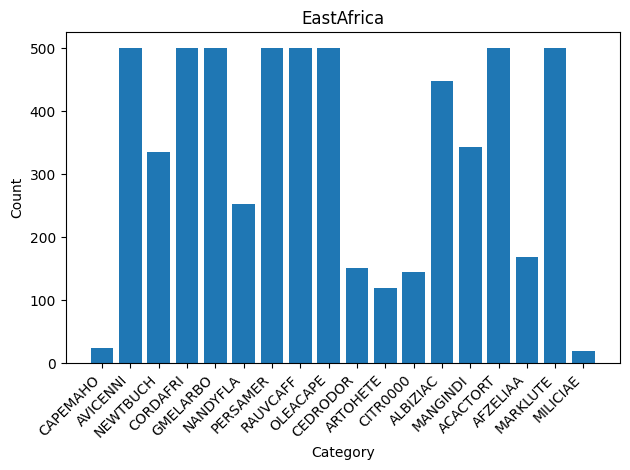

Category: GMELARBO, Count: 500
Category: TECTGRAN, Count: 155
Category: TAMAINDI, Count: 500
Category: MORIOLEI, Count: 500
Category: ANNOMURI, Count: 500
Category: ANACOCCI, Count: 500
Category: GLIRSEPI, Count: 500
Category: AZADINDI, Count: 500
Category: MANGINDI, Count: 500
Total is - 4155


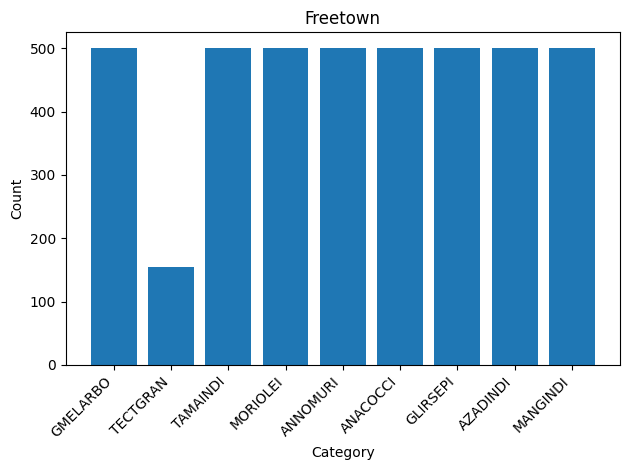

Category: DOMBTORR, Count: 64
Category: SIMAGLAU, Count: 126
Category: CATALONG, Count: 198
Category: MANGINDI, Count: 500
Category: SENNSIAM, Count: 60
Category: ANACOCCI, Count: 125
Category: CEDRODOR, Count: 318
Category: ACACAURI, Count: 217
Total is - 1608


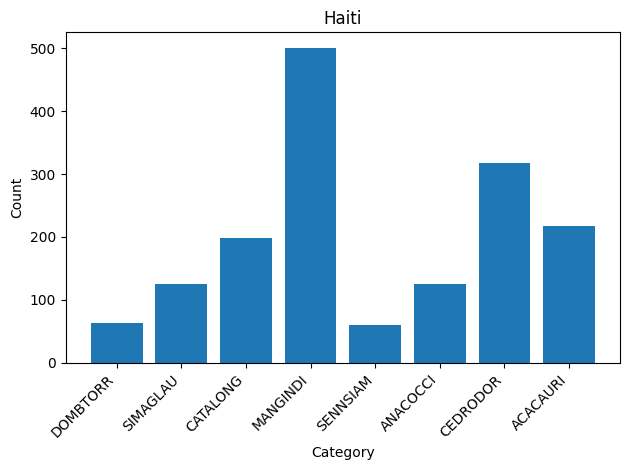

In [8]:
get_distribution(eastafrica_tuple, 'EastAfrica')
get_distribution(freetown_tuple, 'Freetown')
get_distribution(haiti_tuple, 'Haiti')

Category: CAPEMAHO, Count: 24
Category: AVICENNI, Count: 500
Category: NEWTBUCH, Count: 336
Category: CORDAFRI, Count: 500
Category: GMELARBO, Count: 1000
Category: NANDYFLA, Count: 253
Category: PERSAMER, Count: 500
Category: RAUVCAFF, Count: 500
Category: OLEACAPE, Count: 500
Category: CEDRODOR, Count: 469
Category: ARTOHETE, Count: 119
Category: CITR0000, Count: 145
Category: ALBIZIAC, Count: 448
Category: MANGINDI, Count: 1343
Category: ACACTORT, Count: 500
Category: AFZELIAA, Count: 168
Category: MARKLUTE, Count: 500
Category: MILICIAE, Count: 19
Category: TECTGRAN, Count: 155
Category: TAMAINDI, Count: 500
Category: MORIOLEI, Count: 500
Category: ANNOMURI, Count: 500
Category: ANACOCCI, Count: 625
Category: GLIRSEPI, Count: 500
Category: AZADINDI, Count: 500
Category: DOMBTORR, Count: 64
Category: SIMAGLAU, Count: 126
Category: CATALONG, Count: 198
Category: SENNSIAM, Count: 60
Category: ACACAURI, Count: 217
Total is - 11769


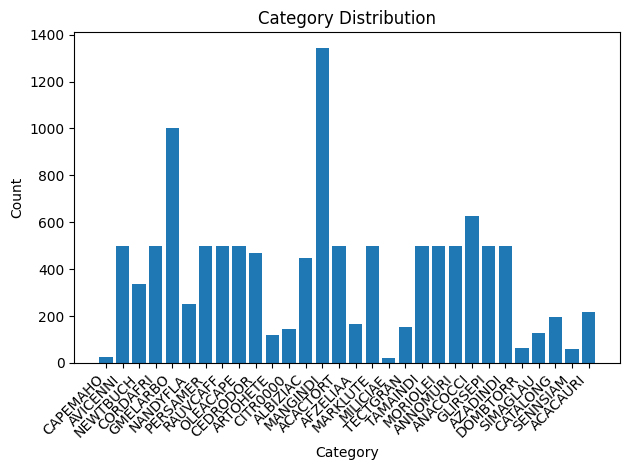

In [9]:
get_distribution(main_tuple)

In [6]:
random.shuffle(main_tuple)
main_tuple_small = random.sample(main_tuple, 1000)
print(len(main_tuple_small))

1000


In [7]:
import pandas as pd
import os
print(os.getcwd())

/teamspace/studios/this_studio/Deeplab


In [8]:
main_dic = dict(main_tuple)

In [10]:
main_dic_small = dict(main_tuple_small)
print(len(main_tuple_small))

1000


In [11]:
df = pd.DataFrame(list(main_dic_small.items()), columns=['File', 'Species'])

# Save the DataFrame to a CSV file with the index named as 'index'
df.to_csv('training_random_1000.csv', index_label='index')


In [14]:
df = pd.DataFrame(list(main_dic.items()), columns=['File', 'Species'])

# Save the DataFrame to a CSV file with the index named as 'index'
df.to_csv('pilot_11769_eastafrica_haiti_freetown_WITH_deeplab_crf_sam.csv', index_label='index')


In [25]:
main_dic_small = dict(main_tuple_small)
df = pd.DataFrame(list(main_dic.items()), columns=['File', 'Species'])
df.to_csv('pilot_small_eastafrica_haiti_freetown_WITH_deeplab_crf_sam.csv', index_label='index')